# Simulate Unbalanced Distribution

In [1]:
import imp
import random
import CustomDataset
import CustomModels
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from CustomDataset import dataset_partition
from setting import *

In [2]:
CIFAR10 = datasets.CIFAR10('./data', train=True, transform=transforms.ToTensor())
MNIST = datasets.MNIST('./data', train=True, transform=transforms.ToTensor())
MNIST_idx_dic = CustomDataset.produce_idx_dic(MNIST.targets)
CIFAR10_idx_dic = CustomDataset.produce_idx_dic(CIFAR10.targets)

In [3]:
# create directories
def create(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
# eg. Indexs/MNIST/p_?/mu_?/
#     Indexs/CIFAR10/p_?/linear/

create("Indexs")
create("Indexs/MNIST")
create("Indexs/CIFAR10")

# directories in MNIST
path = "Indexs/MNIST"
for p in p_MNIST:
    new_dir = os.path.join(path, 'p_'+str(p))
    create(new_dir)
    create(os.path.join(new_dir, EXPONENTIAL))
    create(os.path.join(new_dir, LINEAR))

for p in p_MNIST:
    path_d1 = os.path.join(path, 'p_'+str(p))
    for mu in mu_MNIST:
        new_dir = os.path.join(path_d1, 'mu_'+str(mu))
        create(new_dir)

# # directories in CIFAR10
path = "Indexs/CIFAR10"
for p in p_CIFAR10:
    new_dir = os.path.join(path, 'p_'+str(p))
    create(new_dir)
    create(os.path.join(new_dir, EXPONENTIAL))
    create(os.path.join(new_dir, LINEAR))

for p in p_CIFAR10:
    path_d1 = os.path.join(path, 'p_'+str(p))
    for mu in mu_CIFAR10:
        new_dir = os.path.join(path_d1, 'mu_'+str(mu))
        create(new_dir)


In [4]:
# create base index, seperate train set in to train and validation set
randomState = np.random.RandomState(np.random.seed(12345))
MNIST_eval_idx = CustomDataset.random_select(MNIST_idx_dic, [1000]*10, randomState)
CIFAR10_eval_idx = CustomDataset.random_select(CIFAR10_idx_dic, [1000]*10, randomState)
np.save("Indexs/MNIST_eval", MNIST_eval_idx)
np.save("Indexs/CIFAR10_eval", CIFAR10_eval_idx)

MNIST_all_idx = np.arange(len(MNIST.targets))
MNIST_train_idx = np.delete(MNIST_all_idx, MNIST_eval_idx)
CIFAR10_all_idx = np.arange(len(CIFAR10.targets))
CIFAR10_train_idx = np.delete(CIFAR10_all_idx, CIFAR10_eval_idx)
np.save("Indexs/MNIST_train", MNIST_train_idx)
np.save("Indexs/CIFAR10_train", CIFAR10_train_idx)

In [14]:
# create indexs for each distribution and permutation
def generate_distribution(max_size, num_classes, p, mu, unbalanced_type):
    distribution = np.zeros(num_classes).astype(int)
    if (unbalanced_type == LINEAR):
        diff = (max_size-int(max_size/p))
        for i in range(num_classes):
            distribution[i] = int(np.ceil(max_size - (diff*i/9)))
            
    elif (unbalanced_type == EXPONENTIAL):
        ratio = 1.0/p
        for i in range(num_classes):
            distribution[i] = int(np.ceil(max_size * np.power(ratio,i/9)))
            
    else:
        # STEP unbalanced
        assert(mu is not None)
        min_size = int(np.ceil(max_size/p))
        for i in range(num_classes):
            if(i < int((num_classes+1)*(1-mu))):
                distribution[i] = max_size
            else:
                distribution[i] = min_size
    print("({},p={},mu={}): {}".format(
        unbalanced_type, p, mu, distribution))
    return distribution
        

def generate_indexs(dataset_name, p_list, mu_list, permutations):
    path = os.path.join("Indexs", dataset_name)
    # generate unbalanced train set index
    train_max = train_max_size
    class_size = 10
    for p in p_list:
        num = 0
        for permutation in permutations:
            num += 1
            for mu in mu_list:
                # STEP
                distribution = generate_distribution(train_max, class_size, p, mu, STEP)
                distribution = distribution[np.array(permutation)]
                idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
                file_name = os.path.join(path, "p_"+str(p), "mu_"+str(mu), str(num))
                np.save(file_name, idx)
            
            # LINEAR
            generate_distribution(train_max, class_size, p, None, LINEAR)
            distribution = distribution[np.array(permutation)]
            idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
            file_name = os.path.join(path, "p_"+str(p), LINEAR, str(num))
            np.save(file_name, idx)
            
            # EXPONENTIAL
            generate_distribution(train_max, class_size, p, None, EXPONENTIAL)
            distribution = distribution[np.array(permutation)]
            idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
            file_name = os.path.join(path, "p_"+str(p), EXPONENTIAL, str(num))
            np.save(file_name, idx)
            
    # generate unbalanced evaluation set index
    evaluation_max = train_max_size
    class_size = 10
    for p in p_list:
        num = 0
        for permutation in permutations:
            num += 1
            for mu in mu_list:
                # STEP
                distribution = generate_distribution(evaluation_max, class_size, p, mu, STEP)
                distribution = distribution[np.array(permutation)]
                idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
                file_name = os.path.join(path, "p_"+str(p), "mu_"+str(mu), str(num))
                np.save(file_name, idx)
            
            # LINEAR
            distribution = generate_distribution(evaluation_max, class_size, p, None, LINEAR)
            distribution = distribution[np.array(permutation)]
            idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
            file_name = os.path.join(path, "p_"+str(p), LINEAR, str(num))
            np.save(file_name, idx)
            
            # EXPONENTIAL
            distribution = generate_distribution(evaluation_max, class_size, p, None, EXPONENTIAL)
            distribution = distribution[np.array(permutation)]
            idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
            file_name = os.path.join(path, "p_"+str(p), EXPONENTIAL, str(num))
            np.save(file_name, idx)

In [15]:
generate_indexs('MNIST', p_MNIST, mu_MNIST, permutations)

(step,p=10,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000  400  400]
(step,p=10,mu=0.5): [4000 4000 4000 4000 4000  400  400  400  400  400]
(step,p=10,mu=0.8): [4000 4000  400  400  400  400  400  400  400  400]
(linear,p=10,mu=None): [4000 3600 3200 2800 2400 2000 1600 1200  800  400]
(exponential,p=10,mu=None): [4000 3098 2398 1857 1438 1114  862  668  517  400]
(step,p=10,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000  400  400]
(step,p=10,mu=0.5): [4000 4000 4000 4000 4000  400  400  400  400  400]
(step,p=10,mu=0.8): [4000 4000  400  400  400  400  400  400  400  400]
(linear,p=10,mu=None): [4000 3600 3200 2800 2400 2000 1600 1200  800  400]
(exponential,p=10,mu=None): [4000 3098 2398 1857 1438 1114  862  668  517  400]
(step,p=10,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000  400  400]
(step,p=10,mu=0.5): [4000 4000 4000 4000 4000  400  400  400  400  400]
(step,p=10,mu=0.8): [4000 4000  400  400  400  400  400  400  400  400]
(linear,p=10,mu=None): [4000 3600 3200 280

(exponential,p=250,mu=None): [4000 2166 1173  635  344  187  101   55   30   16]
(step,p=500,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    8    8]
(step,p=500,mu=0.5): [4000 4000 4000 4000 4000    8    8    8    8    8]
(step,p=500,mu=0.8): [4000 4000    8    8    8    8    8    8    8    8]
(linear,p=500,mu=None): [4000 3557 3113 2670 2226 1783 1339  896  452    8]
(exponential,p=500,mu=None): [4000 2006 1006  504  253  127   64   32   16    8]
(step,p=500,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    8    8]
(step,p=500,mu=0.5): [4000 4000 4000 4000 4000    8    8    8    8    8]
(step,p=500,mu=0.8): [4000 4000    8    8    8    8    8    8    8    8]
(linear,p=500,mu=None): [4000 3557 3113 2670 2226 1783 1339  896  452    8]
(exponential,p=500,mu=None): [4000 2006 1006  504  253  127   64   32   16    8]
(step,p=500,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    8    8]
(step,p=500,mu=0.5): [4000 4000 4000 4000 4000    8    8    8    8    8]
(step,p=500,mu=0.8): 

(step,p=10,mu=0.5): [4000 4000 4000 4000 4000  400  400  400  400  400]
(step,p=10,mu=0.8): [4000 4000  400  400  400  400  400  400  400  400]
(linear,p=10,mu=None): [4000 3600 3200 2800 2400 2000 1600 1200  800  400]
(exponential,p=10,mu=None): [4000 3098 2398 1857 1438 1114  862  668  517  400]
(step,p=10,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000  400  400]
(step,p=10,mu=0.5): [4000 4000 4000 4000 4000  400  400  400  400  400]
(step,p=10,mu=0.8): [4000 4000  400  400  400  400  400  400  400  400]
(linear,p=10,mu=None): [4000 3600 3200 2800 2400 2000 1600 1200  800  400]
(exponential,p=10,mu=None): [4000 3098 2398 1857 1438 1114  862  668  517  400]
(step,p=25,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000  160  160]
(step,p=25,mu=0.5): [4000 4000 4000 4000 4000  160  160  160  160  160]
(step,p=25,mu=0.8): [4000 4000  160  160  160  160  160  160  160  160]
(linear,p=25,mu=None): [4000 3574 3147 2720 2294 1867 1440 1014  587  160]
(exponential,p=25,mu=None): [4000 2798 

(linear,p=500,mu=None): [4000 3557 3113 2670 2226 1783 1339  896  452    8]
(exponential,p=500,mu=None): [4000 2006 1006  504  253  127   64   32   16    8]
(step,p=500,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    8    8]
(step,p=500,mu=0.5): [4000 4000 4000 4000 4000    8    8    8    8    8]
(step,p=500,mu=0.8): [4000 4000    8    8    8    8    8    8    8    8]
(linear,p=500,mu=None): [4000 3557 3113 2670 2226 1783 1339  896  452    8]
(exponential,p=500,mu=None): [4000 2006 1006  504  253  127   64   32   16    8]
(step,p=500,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    8    8]
(step,p=500,mu=0.5): [4000 4000 4000 4000 4000    8    8    8    8    8]
(step,p=500,mu=0.8): [4000 4000    8    8    8    8    8    8    8    8]
(linear,p=500,mu=None): [4000 3557 3113 2670 2226 1783 1339  896  452    8]
(exponential,p=500,mu=None): [4000 2006 1006  504  253  127   64   32   16    8]
(step,p=1000,mu=0.2): [4000 4000 4000 4000 4000 4000 4000 4000    4    4]
(step,p=1000,mu=0

In [34]:
os.path.join("a","b","c")

'a/b/c'

In [32]:
np.power(np.power(1.0/2, 0), 9)

1.0

In [8]:
# get indexs for each targets
MNIST_idx_dic = CustomDataset.produce_idx_dic(MNIST.targets)
CIFAR10_idx_dic = CustomDataset.produce_idx_dic(CIFAR10.targets)

In [9]:
# randomly select index and store as a npy file
randomState = np.random.RandomState(np.random.seed(12345))
for i in range(len(names)-1, len(names)):
    distribution = np.array(shapes[i])[permutation]
    MNIST_new_idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
    CIFAR10_new_idx = CustomDataset.random_select(CIFAR10_idx_dic, distribution, randomState)
    
    np.save("./data/MNIST_"+names[i], MNIST_new_idx)
    np.save("./data/CIFAR10_"+names[i], CIFAR10_new_idx)
    

In [21]:
# produce evaluation set indexs
permutation = np.array([9, 2, 3, 4, 7, 5, 0, 6, 8, 1])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

CIFAR10 = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

MNIST = datasets.MNIST('./data', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

MNIST_idx_dic = CustomDataset.produce_idx_dic(MNIST.targets)
CIFAR10_idx_dic = CustomDataset.produce_idx_dic(CIFAR10.targets)

randomState = np.random.RandomState(np.random.seed(32131))
for i in range(0, len(names)):
    distribution =((np.array(shapes[i])[permutation] / 6) + 5).astype(int)
    MNIST_new_idx = CustomDataset.random_select(MNIST_idx_dic, distribution, randomState)
    MNIST_test_idx = np.delete(np.arange(len(MNIST.targets)), MNIST_new_idx, axis=0)
    np.save("./data/MNIST_"+names[i]+"_eval", MNIST_new_idx)
    np.save("./data/MNIST_"+names[i]+"_test", MNIST_test_idx)
    
    CIFAR10_new_idx = CustomDataset.random_select(CIFAR10_idx_dic, distribution, randomState)
    CIFAR10_test_idx = np.delete(np.arange(len(CIFAR10.targets)), CIFAR10_new_idx, axis=0)
    np.save("./data/CIFAR10_"+names[i]+"_eval", CIFAR10_new_idx)
    np.save("./data/CIFAR10_"+names[i]+"_test", CIFAR10_test_idx)
    

Files already downloaded and verified


In [6]:
# duplicate samples in expo_unbalance_2560to5 make it have the same size as balance_2560, compare with balance_2560
Dataset = 'MNIST'
Original_Distribution = 'expo_unbalance_2560to5'
Rescaled_Distribution = '2560to5_rescaled'
Rescaled_Number = 2560

In [5]:
randomState = np.random.RandomState(np.random.seed(12345))
target_dataset = CustomDataset.load_dataset(dataset_name=Dataset, distribution_name=Original_Distribution, transform = None, data_folder="./data")
target_idx_dic = CustomDataset.produce_idx_dic(target_dataset.targets)
result_idxs = CustomDataset.duplicate_idxs(target_idx_dic, Rescaled_Number, randomState=randomState)
np.save("./data/"+Dataset+"_"+Rescaled_Distribution, np.load("./data/"+Dataset+"_"+Original_Distribution+".npy")[result_idxs])

NameError: name 'Dataset' is not defined

In [16]:
#test
test = CustomDataset.CustomMNIST("./data", 
                                 indexs_name="MNIST_2560to5_rescaled.npy")
dic = CustomDataset.produce_idx_dic(test.targets)

0
5
1
640
2
320
3
160
4
20
5
80
6
2560
7
40
8
10
9
1280


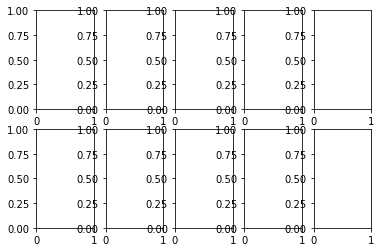

In [17]:
fig = plt.figure()
for (k,v) in dic.items():
    plt.subplot(2,5,k+1)
    print(k)
    print(len(v))
    #plt.imshow(test[v[10]][0][0,:,:], cmap='gray', interpolation='none')

In [ ]:
# Produce targrt transform and index transform on datasets use by the hierarchical method

In [5]:
# target dataset MNIST_expo_unbalance_2560to5
Dataset = 'MNIST'
Distribution = 'expo_unbalance_2560to5'
randomState = np.random.RandomState(np.random.seed(12345))
target_dataset, _, _ = CustomDataset.load_dataset(dataset_name=Dataset, distribution_name=Distribution, transform = None, data_folder="./data")
target_idx_dic = CustomDataset.produce_idx_dic(target_dataset.targets)
origin_indexs = np.load("./data/"+Dataset+"_"+Distribution +".npy")

897


In [6]:
origin_indexs

array([   13,    14,    19, ..., 59983, 59986, 59998])

In [7]:
target_idx_dic[0]

[414, 1748, 2611, 3507, 3853]

In [8]:
# using binary splits on the targets
dtype = [('key', int), ('size', int)]
sizes = np.array([(0,0)]*len(target_idx_dic.keys()), dtype)
total_size = 0

for (k,v) in target_idx_dic.items():
    sizes[k] = (k,len(v))
    total_size = total_size + len(v)

sizes[::-1].sort(order='size')

def recursive_partition(sizes, total_size):
    if (len(sizes) == 1):
        return sizes[0]
    
    class_one_size = 0
    index = 0
    while class_one_size < total_size/2:
        class_one_size = class_one_size + sizes[index][1]
        index = index+1
    return [
        recursive_partition(sizes[0:index], class_one_size), 
        recursive_partition(sizes[index:], total_size-class_one_size)
    ]

In [9]:
class_partition = recursive_partition(sizes, total_size)

In [10]:
isinstance(class_partition, list)

True

In [11]:
class_partition

[(6, 2560),
 [(9, 1280),
  [(1, 640),
   [(2, 320),
    [(3, 160), [(5, 80), [(7, 40), [(4, 20), [(8, 10), (0, 5)]]]]]]]]]

In [12]:
# TODO: build levels of classifers and datasets based on the given hierarchical structure

In [19]:
def build_datasets_partition(target_idx_dic, class_partition, origin_indexs):
    # dataset_partition : (idxs, classes, children) | (idxs, old_class_number)
    # children : [dataset_partition, dataset_partition]
    # this function will return an dataset_partition build from the root of class_partition
    classes = np.array([-1]*10)
    children = []
    class_number = 0
    for child_class_partition in class_partition:
        if isinstance(child_class_partition, list):
            # build child partition for the classes
            child_dataset_partition = build_datasets_partition(target_idx_dic, child_class_partition, origin_indexs)
            children.append(child_dataset_partition)
            # all classes in the child partition will be merged into single class of current partition
            classes[child_dataset_partition.classes!=-1] = class_number
        else:
            # no child partition, single class
            old_class_number = child_class_partition[0]
            children.append(
                dataset_partition(
                    idxs = origin_indexs[target_idx_dic[old_class_number]], 
                    old_class_number = old_class_number
                )
            )
            classes[old_class_number] = class_number
        class_number = class_number+1
    
    return dataset_partition(classes=classes, children=children)

def check_dataset_partition(target_idx_dic, partition):
    classes = np.array([0,1,2,3,4,5,6,7,8,9])
    frontier = partition.children[:]
    while len(frontier) != 0:
        item = frontier.pop(0)
        if (not item.has_children):
            print(item.old_class_number)
        else:
            frontier = frontier+item.children[:]
            temp = classes[item.classes!=-1]
            print(temp)
    
    

In [20]:
a = build_datasets_partition(target_idx_dic, class_partition, origin_indexs)

In [37]:
import pickle 
filehandler = open('./data/partition_object_test.txt', 'wb') 
pickle.dump(a, filehandler)

In [46]:
import pickle 
filehandler = open('./data/partition_object_test.txt', 'rb') 
a_2 = pickle.load(filehandler)

In [52]:
d=CustomDataset.load_partition_dataset("MNIST", a_2.children[1], None, train=True, data_folder="./data")

In [53]:
dic = CustomDataset.produce_idx_dic(d.targets)

In [54]:
for (k,v) in dic.items():
    print(len(v))

1280
1275


In [51]:
check_dataset_partition(target_idx_dic, a_2)

6
Number: 2560
[0 1 2 3 4 5 7 8 9]
Number: 2555
9
Number: 1280
[0 1 2 3 4 5 7 8]
Number: 1275
1
Number: 640
[0 2 3 4 5 7 8]
Number: 635
2
Number: 320
[0 3 4 5 7 8]
Number: 315
3
Number: 160
[0 4 5 7 8]
Number: 155
5
Number: 80
[0 4 7 8]
Number: 75
7
Number: 40
[0 4 8]
Number: 35
4
Number: 20
[0 8]
Number: 15
8
Number: 10
0
Number: 5


In [12]:
# finished

In [6]:
np.array([-1,1,1])[True]

array([[-1,  1,  1]])

In [1]:
"\n".join(str(item) for item in [1,1,1,1])

'1\n1\n1\n1'

In [45]:
m = CustomModels.load_model('Custom_05', 1,  2)
target_dataset = datasets.MNIST('./data', train=False, download=True,
                                transform=transforms.Compose([
                            transforms.Pad(2, fill=0, padding_mode='constant'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [46]:
loader= torch.utils.data.DataLoader(target_dataset, batch_size=10, shuffle=True, num_workers=4)

In [32]:
pic = (target_dataset[0][0])
tensor = transforms.ToTensor()(pic)
tensor.unsqueeze_(0)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [48]:
a = loader.__iter__().next()

In [72]:
a[0].shape[0]

10

In [33]:
tensor.shape

torch.Size([1, 1, 32, 32])

In [58]:
result = m(a[0])

In [74]:
result.data[:,0]

tensor([-0.7331, -0.6521, -0.4208, -0.5569, -0.6298, -1.0289, -1.0347, -0.4753,
        -0.6981, -0.7299])

In [73]:
np.exp(result.data.numpy())

array([[0.48041195, 0.519588  ],
       [0.52097166, 0.47902843],
       [0.6565223 , 0.34347776],
       [0.5729933 , 0.42700675],
       [0.53271914, 0.46728086],
       [0.357414  , 0.642586  ],
       [0.35531732, 0.64468265],
       [0.62169015, 0.37830985],
       [0.49755234, 0.50244766],
       [0.48194927, 0.51805073]], dtype=float32)

10

In [34]:
m = torch.tensor([[1,2],
             [1,2],
                 [2,1]])
n = torch.argmax(m,axis=1)

In [35]:
np.log(0.99)

-0.01005033585350145

In [36]:
n

tensor([1, 1, 0])

In [44]:
m[np.arange(len(m)),n]
m[:,:] = 1

In [45]:
m

tensor([[1, 1],
        [1, 1],
        [1, 1]])

In [66]:
(np.array([1,2,3,4]) == 3) and (np.array([1,0,1,0])==1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [77]:
a = 1
a += 1

In [78]:
a

2

In [91]:
a = np.zeros((10,10))
a[:, np.array([1,1,1,0,0,0,1,1,1,0]) == 1] += result.data[:,0].numpy().reshape((10,1))

In [92]:
a

array([[-0.73311132, -0.73311132, -0.73311132,  0.        ,  0.        ,
         0.        , -0.73311132, -0.73311132, -0.73311132,  0.        ],
       [-0.65205967, -0.65205967, -0.65205967,  0.        ,  0.        ,
         0.        , -0.65205967, -0.65205967, -0.65205967,  0.        ],
       [-0.42079869, -0.42079869, -0.42079869,  0.        ,  0.        ,
         0.        , -0.42079869, -0.42079869, -0.42079869,  0.        ],
       [-0.55688125, -0.55688125, -0.55688125,  0.        ,  0.        ,
         0.        , -0.55688125, -0.55688125, -0.55688125,  0.        ],
       [-0.62976092, -0.62976092, -0.62976092,  0.        ,  0.        ,
         0.        , -0.62976092, -0.62976092, -0.62976092,  0.        ],
       [-1.02886045, -1.02886045, -1.02886045,  0.        ,  0.        ,
         0.        , -1.02886045, -1.02886045, -1.02886045,  0.        ],
       [-1.03474402, -1.03474402, -1.03474402,  0.        ,  0.        ,
         0.        , -1.03474402, -1.03474402

In [87]:
result.data[:,0].reshape((10,1))

tensor([[-0.7331],
        [-0.6521],
        [-0.4208],
        [-0.5569],
        [-0.6298],
        [-1.0289],
        [-1.0347],
        [-0.4753],
        [-0.6981],
        [-0.7299]])

In [25]:
cm = np.load("MNIST_hierarchical_test_whole_system_test/result_outputs/confusion_matrix.npy").astype(int)
cm

array([[ 832,    0,   56,    0,    2,    3,   40,   10,   15,   22],
       [   0, 1128,    4,    0,    0,    1,    1,    0,    0,    1],
       [   1,    1, 1013,    3,    1,    0,    3,    6,    4,    0],
       [   3,    0,    5,  948,    2,   30,    0,   11,   10,    1],
       [   0,    6,   15,    0,  822,    0,    8,    5,    9,  117],
       [   1,   17,    3,    8,    3,  838,    8,    4,    5,    5],
       [   0,    2,    2,    0,    1,    1,  952,    0,    0,    0],
       [   3,   18,   35,    3,    7,    1,    0,  891,    4,   66],
       [  13,    3,   18,   38,   21,   60,   24,    7,  691,   99],
       [   4,    1,    1,    0,    4,    1,    1,    8,    3,  986]])

In [27]:
np.average(np.sum(np.eye(10)* cm,1) / np.sum(cm,1))

0.9086663501138753

In [9]:
np.exp(1)

2.718281828459045

In [12]:
np.sum(cm,0)[9]

2440.0

In [13]:
np.sum(cm)

10000.0